In [47]:
from PIL import Image, ImageFont, ImageDraw 
import glob
import string
import random
import os
import shutil
import math
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

2.6.0


In [48]:
unmarked_path = "C:/Users/Scrip0/Desktop/Training/Unmarked" # Path to marked images
marked_path = os.path.dirname(unmarked_path) + "/Marked"
unmarked_imgs = []
marked_imgs = []
ext = ["jpg","png", "jpeg"];
for file in (file for file in (glob.glob(unmarked_path + '/*.%s' % e) for e in ext) if file != []):
    for image in file:
        unmarked_imgs.append(image)

In [49]:
def generate_word():
    letters = string.ascii_letters + string.digits + string.punctuation;
    return "".join(random.choice(letters) for i in range(random.randint(5, 20)))

In [50]:
class point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
def generate_points(width, height, angle, side):
    points = []
    num = random.randint(2, 5)
    half_width = int(width / 2)
    gap = int(height / (num - 1)) 
    if (side == "right"): gap = int(gap * 1.5)
    extra = random.randint(0, gap)
    for i in range(0, num):
        points.append(point(half_width, gap * i - extra))
        
    if (side == "right"):
        more = int(((-half_width * math.tan(math.radians(angle))) - extra) / gap)  + 1
    else:
        more = int(((half_width * math.tan(math.radians(angle))) - extra) / gap)  + 1
    for i in range(-more - 1, 0):
        points.insert(0, point(half_width, gap * i - extra))
    for i in range(num, num + more):
        points.append(point(half_width, gap * i - extra))
    return points

def draw_lines_left(image, angle, watermark, line, color, opacity, size):
    points = generate_points(image.size[0], image.size[1], angle, "left")
    half_width = int(image.width / 2)
    tan = math.tan(math.radians(angle))
    for point in points:
        x = 0
        y = int(half_width * tan + point.y)
        while (x < image.width):
            image.paste(watermark, (x, y), watermark)
            line = Image.new('RGBA', image.size, (255,255,255,0))
            draw = ImageDraw.Draw(line)
            line_width = size * 3
            draw.line((x + watermark.width, y, x + watermark.width + line_width, y - line_width * tan), fill=(color[0], color[1], color[2], opacity), width=int(size / 7))
            image.alpha_composite(line)
            x += watermark.width + line_width
            y -= int(line_width * tan) + watermark.height
            
def draw_lines_right(image, angle, watermark, line, color, opacity, size):
    points = generate_points(image.size[0], image.size[1], angle, "right")
    half_width = int(image.width / 2)
    tan = math.tan(math.radians(angle))
    for point in points:
        x = image.width - watermark.width
        y = int(-half_width * tan + point.y)
        while (x > -watermark.width):
            image.paste(watermark, (x, y), watermark)
            line = Image.new('RGBA', image.size, (255,255,255,0))
            draw = ImageDraw.Draw(line)
            line_width = size * 3
            draw.line((x, y, x - line_width, y + line_width * tan), fill=(color[0], color[1], color[2], opacity), width=int(size / 7))
            image.alpha_composite(line)
            x -= watermark.width + line_width
            y -= -int(line_width * tan) + watermark.height

In [51]:
if (os.path.isdir(marked_path)): shutil.rmtree(marked_path, ignore_errors=True)
os.mkdir(marked_path)
for img in unmarked_imgs:
    angle = random.randint(30, 60)
    color = random.randint(0, 256), random.randint(0, 256), random.randint(0, 256)
    opacity = random.randint(40, 250)
    image = Image.open(img)
    image = image.convert('RGBA')
    text = generate_word()
    size = random.randint(10, 30)
    font = ImageFont.truetype("impact.ttf", size)
    
    watermark = Image.new('RGBA', font.getsize(text), (255,255,255,0))
    d = ImageDraw.Draw(watermark)    
    d.text((0, 0), text, fill=(color[0], color[1], color[2], opacity), font=font)
    
    watermark = watermark.rotate(angle, expand = 1)
    draw_lines_left(image, angle, watermark, image, color, opacity, size)
    
    watermark = watermark.rotate(-90, expand = 1)
    draw_lines_right(image, -90 + angle, watermark, image, color, opacity, size)
    path = marked_path + "/" + os.path.splitext(os.path.basename(img))[0] + ".png"
    image.save(path)
    
    marked_imgs.append(path)

In [52]:
width = 200
height = 200
def createPixelArr(files):
    data = []
    for image in files:# take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
    return np.array(data)

In [53]:
train_marked = createPixelArr(marked_imgs)
train_unmarked = createPixelArr(unmarked_imgs)
unmarked_imgs = []
marked_imgs = []

In [54]:
x_train, x_test, y_train, y_test = train_test_split(train_marked, train_unmarked, train_size=0.8, random_state=1) 
train_marked = []
train_unmarked = []

In [55]:
def scale(data):
    return data / 256
x_train = scale(x_train)
x_test = scale(x_test)
y_train = scale(y_train)
y_test = scale(y_test)

In [56]:
print(x_train.shape)
print(y_train.shape)

(1763, 200, 200, 3)
(1763, 200, 200, 3)


In [57]:
model = keras.Sequential()

model.add(keras.Input(shape=(width, height, 3))) #3 if RGB, 1 if GrayScale

model.add(tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.UpSampling2D(2))

model.add(tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.UpSampling2D(2))

model.add(tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"))
model.add(tf.keras.layers.UpSampling2D(2))

model.add(tf.keras.layers.Conv2D(3, 3, activation="sigmoid", padding="same"))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 200, 200, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 16)       

In [59]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="MeanSquaredError")

In [60]:
early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=20, epochs=5, callbacks=[early_stop])

Epoch 1/5
89/89 [==============================] - 169s 2s/step - loss: 0.0326
Epoch 2/5
89/89 [==============================] - 178s 2s/step - loss: 0.0133
Epoch 3/5
89/89 [==============================] - 175s 2s/step - loss: 0.0115
Epoch 4/5
89/89 [==============================] - 171s 2s/step - loss: 0.0106
Epoch 5/5
89/89 [==============================] - 167s 2s/step - loss: 0.0102


In [61]:
model.save('Watermark.h5')

In [ ]:
# model = keras.models.load_model('Watermark.h5') # If you want to load saved model

In [65]:
result = model.predict(x_test)
model.evaluate(result, y_test)

14/14 [==============================] - 7s 485ms/step - loss: 0.0119


0.011937362141907215

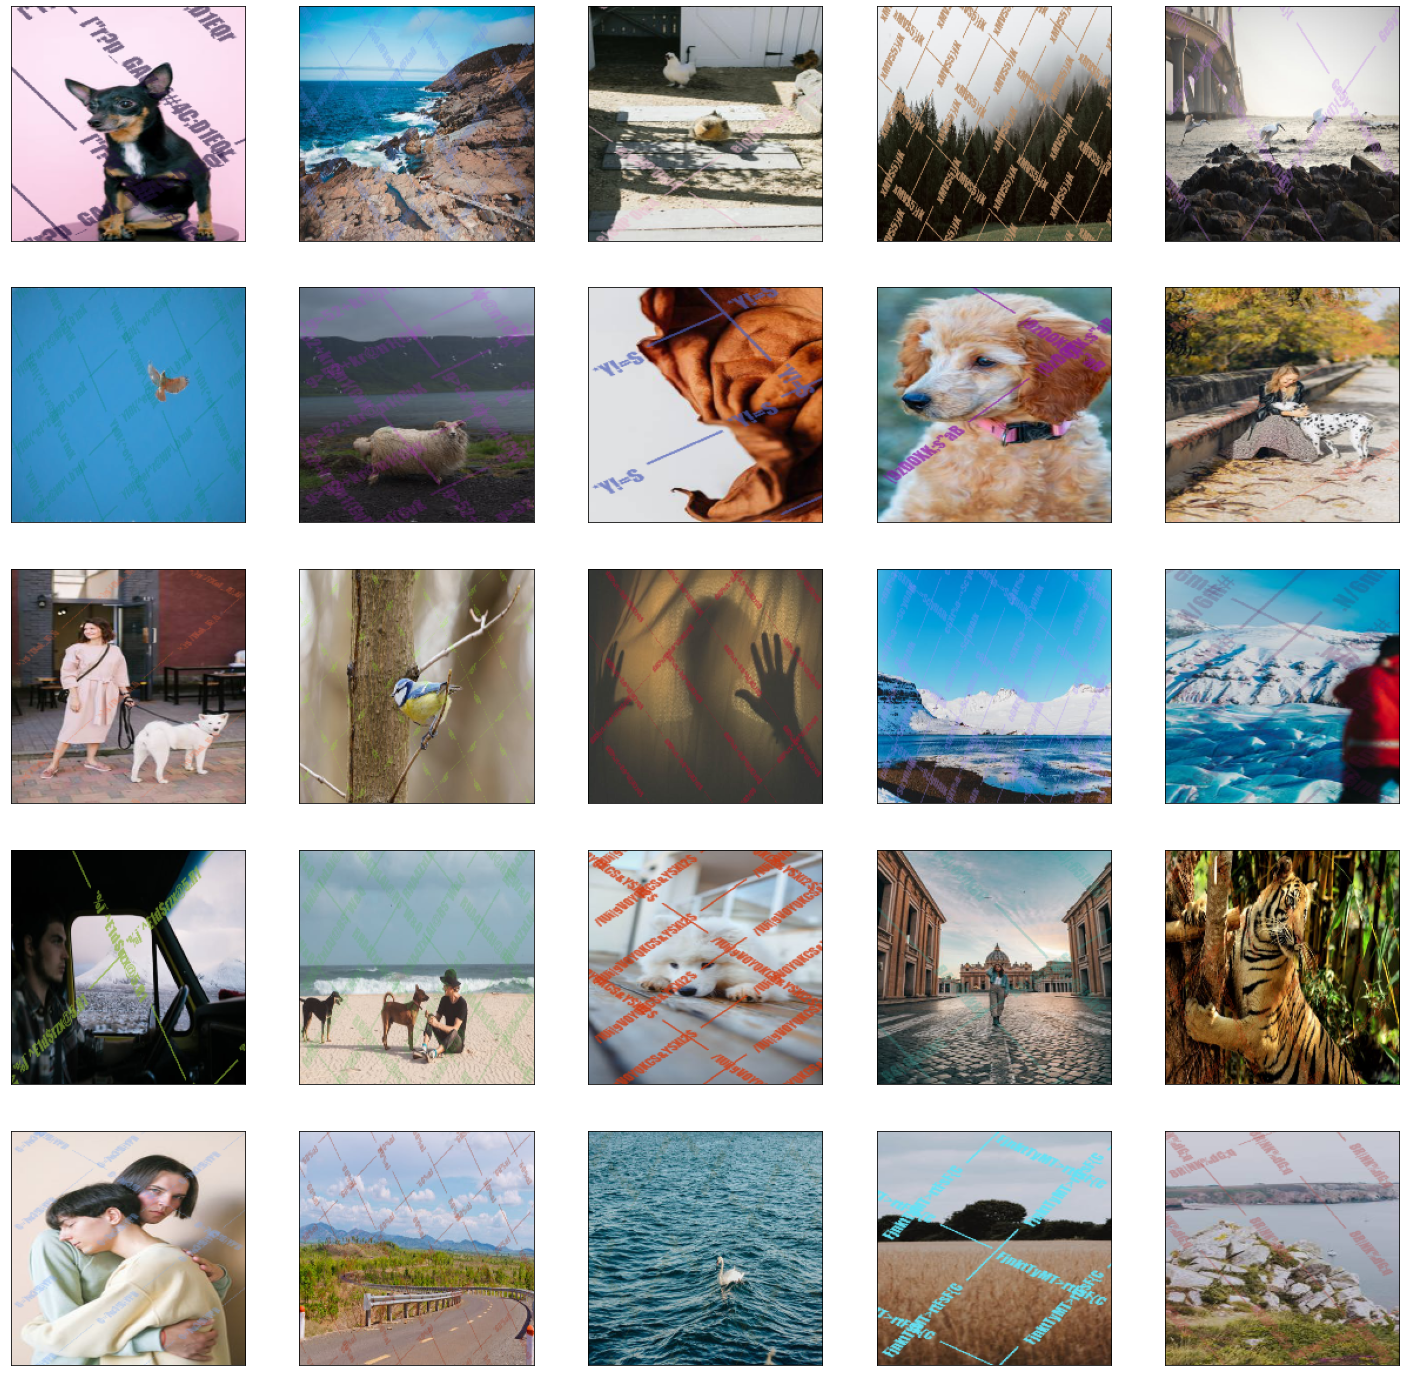

In [66]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(x_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

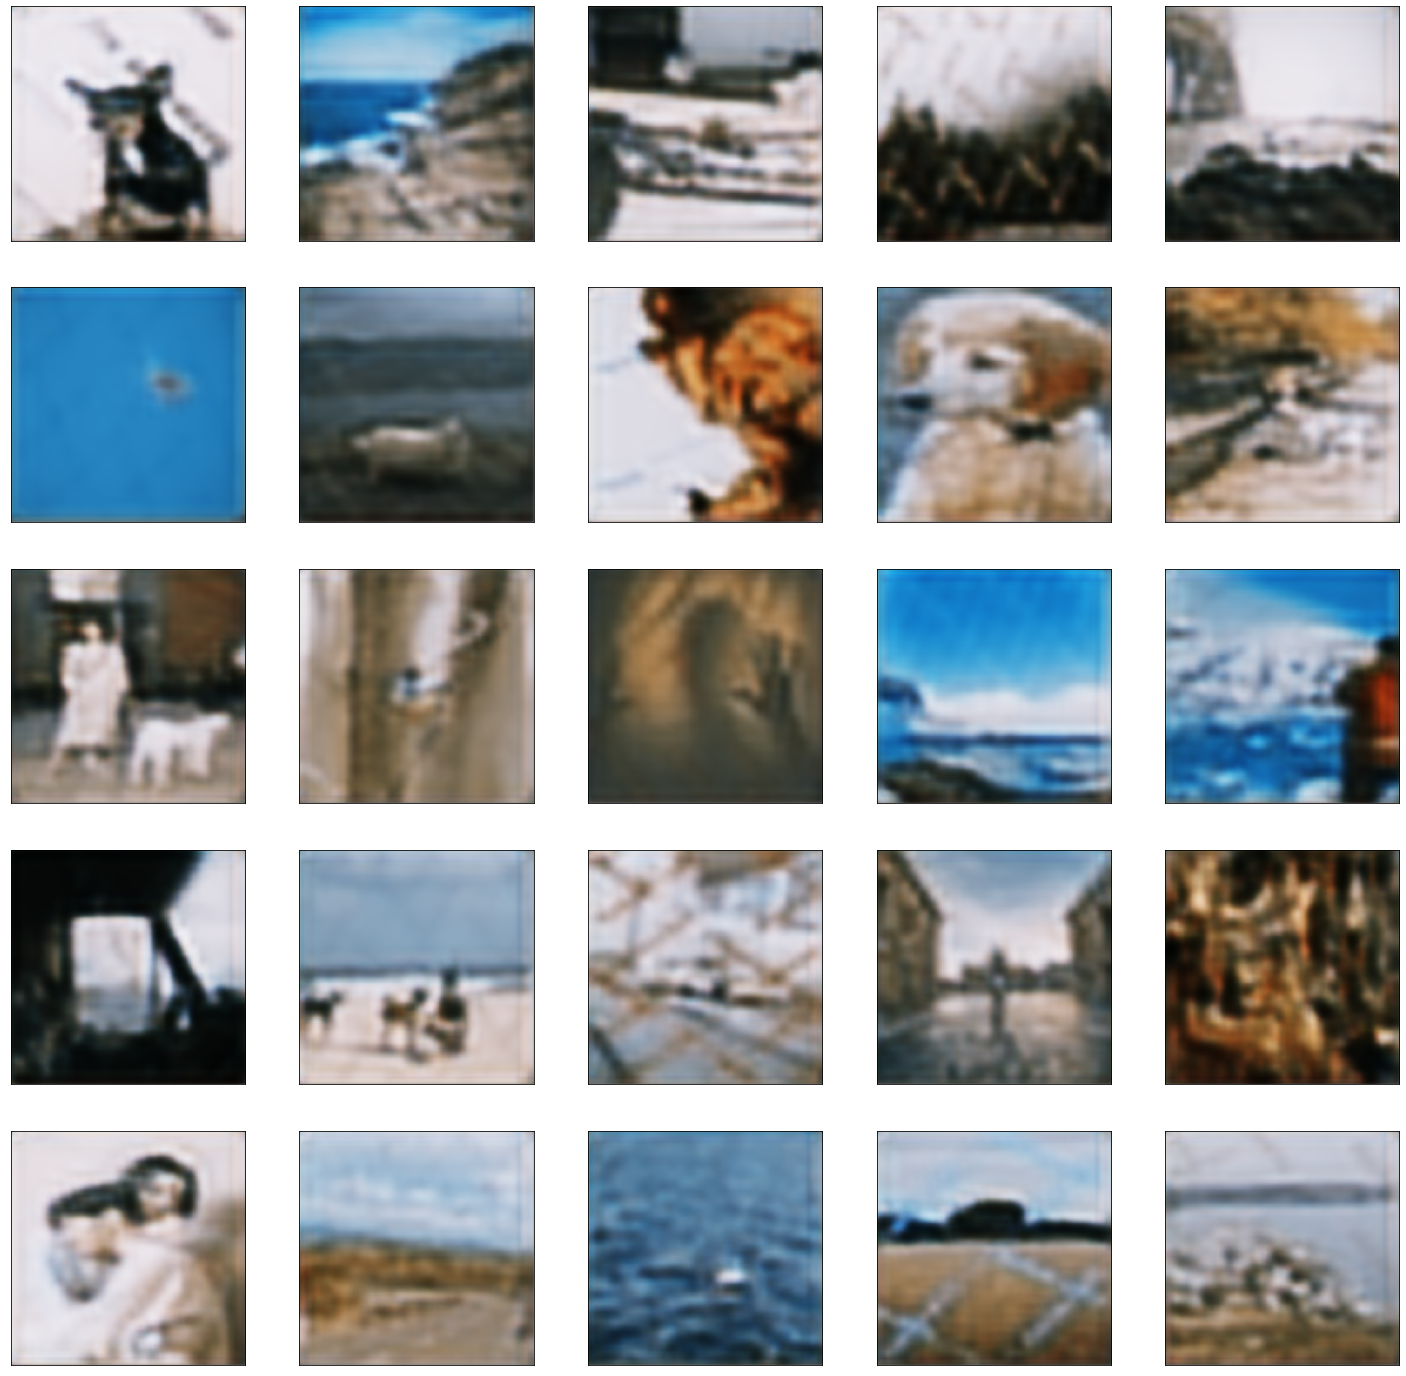

In [67]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()